In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
import pandas as pd

%matplotlib inline

In [2]:
os.listdir('../input')

['tensorflow-speech-recognition-challenge', 'testing']

In [3]:
train_audio_path = '../input/tensorflow-speech-recognition-challenge/train/audio'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

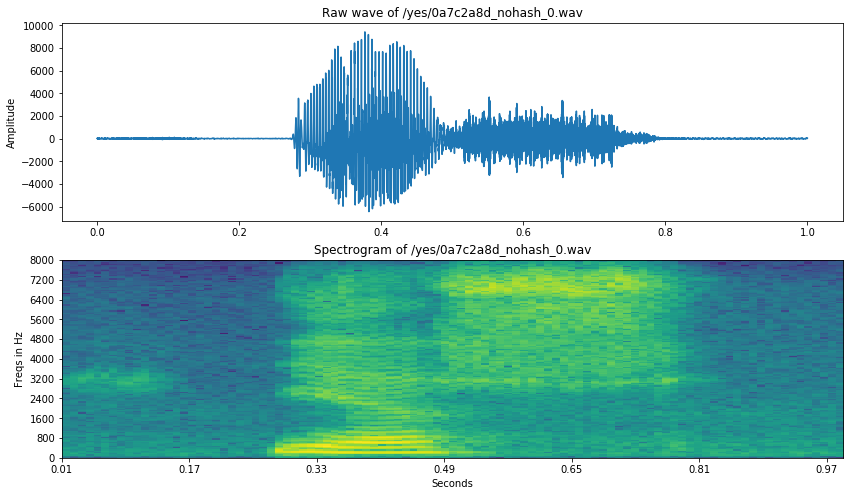

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [6]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram1 = (spectrogram - mean) / std

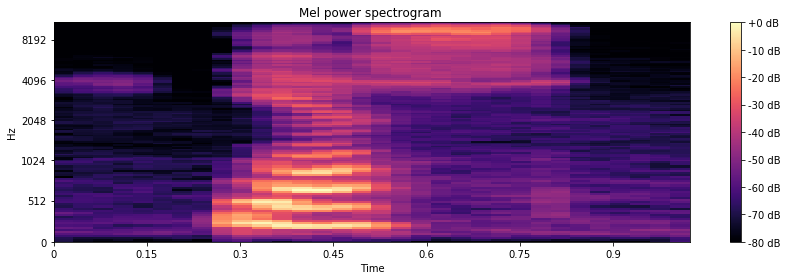

In [7]:
S = librosa.feature.melspectrogram(np.array(samples, dtype=np.float), sr=sample_rate, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



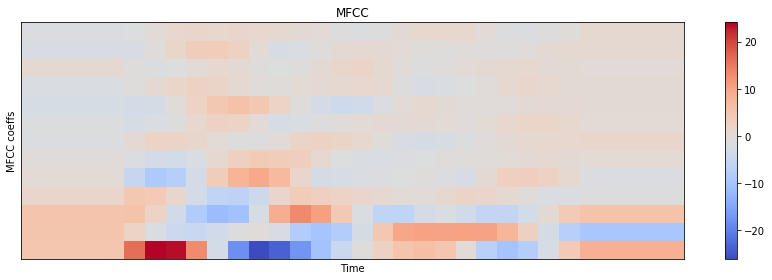

In [8]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [9]:
std_mfcc = (mfcc - np.mean(mfcc))/np.std(mfcc)
print("standardize : ", std_mfcc[0])
norm_mfcc = (mfcc - np.min(mfcc))/(np.max(mfcc) - np.min(mfcc))
print("\nnormalized : ", norm_mfcc[0])

standardize :  [-4.16836544 -4.1030522  -4.07403903 -4.09317812 -4.13105384 -4.2329017
 -4.30483083 -4.26620958 -3.68875438 -3.01052325 -2.44292131 -2.10848691
 -2.06222023 -2.12350509 -2.23699718 -2.31499009 -2.4946927  -2.72030658
 -2.87653661 -2.96985157 -3.02899141 -3.03415602 -3.02056076 -3.08246406
 -3.10155804 -3.36485988 -3.81018463 -3.97698701 -4.00704017 -4.00696171
 -4.04118011 -4.05043552]

normalized :  [0.02579028 0.03813368 0.04361681 0.03999976 0.03284171 0.01359372
 0.         0.00729894 0.11643086 0.24460819 0.35187797 0.41508195
 0.42382578 0.4122437  0.39079509 0.37605539 0.34209381 0.29945557
 0.26993002 0.25229464 0.24111794 0.24014189 0.24271122 0.23101226
 0.22740374 0.17764293 0.09348204 0.06195844 0.05627877 0.05629359
 0.04982674 0.04807758]


In [10]:
def build(filename):
    max_pad = 35
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
#     freqs, times, spectrogram = log_specgram(samples, sample_rate)
#     mean = np.mean(spectrogram, axis=0)
#     std = np.std(spectrogram, axis=0)
#     spectrogram = (spectrogram - mean) / std
    S = librosa.feature.melspectrogram(np.array(samples, dtype=np.float), sr=sample_rate, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    pad_width = max_pad - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Let's pad on the first and second deltas while we're at it
#     delta2_mfcc = librosa.feature.delta(mfcc, order=2)
#     std_mfcc = (mfcc - np.mean(mfcc))/np.std(mfcc)
#     std_delta2_mfcc = (delta2_mfcc - np.mean(delta2_mfcc))/np.std(delta2_mfcc)
    norm_mfcc = (mfcc - np.min(mfcc))/(np.max(mfcc) - np.min(mfcc))
#     norm_delta2_mfcc = (delta2_mfcc - np.min(delta2_mfcc))/(np.max(delta2_mfcc) - np.min(delta2_mfcc))
    return norm_mfcc

In [11]:
class AudioFeatureDataset():
    ''' Creates Audio Dataset and extracts features from RAW wav files '''
    def __init__(self,file_path):
        self.file_path = file_path
        self.labels = os.listdir(self.file_path)
        self.target_labels = ['no', 'seven', 'right', 'up', 'down', 'eight', 'six', 'wow', 'bird', 'tree', 'happy', 'three', 'five', 'zero', 'go', 'left', 'nine', 'two', 'four', 'yes', 'bed', 'stop', 'cat', 'dog', 'marvin', 'off', 'one', 'on', 'sheila', 'house']
        self.data_dict = {}
        for tl in self.target_labels:
            files_dir = os.path.join(file_path,tl)
            all_audio_fp_s =[ os.path.join(files_dir,f) for f in os.listdir(files_dir)]
            self.data_dict[tl] = all_audio_fp_s
    
    def process(self,file,max_pad = 35):
        samps,sr = librosa.load(file, mono=True, sr=None)
        mfcc = librosa.feature.mfcc(samps, sr = sr)
        pad_width = max_pad - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfcc
    def get_features(self):
        labels =  []
        features = []
        for t in tqdm(self.target_labels):
            for fp in tqdm(self.data_dict[t]):
                labels.append(t)
                features.append(self.process(fp))
        return labels, features

In [12]:
# X,Y = [], []
# for file in os.listdir(train_audio_path):
#     if file == '_background_noise_':
#         continue
#     for f in os.listdir(train_audio_path+'/'+file):
#         X.append(file+'/'+f)
#         Y.append(file)
# df = pd.DataFrame({'X':X, 'Y':Y})

In [13]:
audio_data = AudioFeatureDataset(train_audio_path)
Y,X = audio_data.get_features()
X = np.array(X)
Y = np.array(Y)

100%|██████████| 30/30 [07:06<00:00, 12.87s/it]


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, onehot_encoded, test_size=0.30, random_state=42)
x_train = X_train.reshape((45304, 20, 35,1))

[14 14 14 ... 10 10 10]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



In [15]:
from __future__ import absolute_import, division


import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD


import tensorflow as tf
from keras.layers import Conv2D
from keras.initializers import RandomNormal
from keras.layers import Input, Conv2D, Activation, GlobalAvgPool2D, Dense, BatchNormalization

from scipy.ndimage.interpolation import map_coordinates as sp_map_coordinates
import tensorflow as tf


def tf_flatten(a):
    """Flatten tensor"""
    return tf.reshape(a, [-1])


def tf_repeat(a, repeats, axis=0):
    """TensorFlow version of np.repeat for 1D"""
    # https://github.com/tensorflow/tensorflow/issues/8521
    assert len(a.get_shape()) == 1

    a = tf.expand_dims(a, -1)
    a = tf.tile(a, [1, repeats])
    a = tf_flatten(a)
    return a


def tf_repeat_2d(a, repeats):
    """Tensorflow version of np.repeat for 2D"""

    assert len(a.get_shape()) == 2
    a = tf.expand_dims(a, 0)
    a = tf.tile(a, [repeats, 1, 1])
    return a


def tf_map_coordinates(input, coords, order=1):
    """Tensorflow verion of scipy.ndimage.map_coordinates
    Note that coords is transposed and only 2D is supported
    Parameters
    ----------
    input : tf.Tensor. shape = (s, s)
    coords : tf.Tensor. shape = (n_points, 2)
    """

    assert order == 1

    coords_lt = tf.cast(tf.floor(coords), 'int32')
    coords_rb = tf.cast(tf.ceil(coords), 'int32')
    coords_lb = tf.stack([coords_lt[:, 0], coords_rb[:, 1]], axis=1)
    coords_rt = tf.stack([coords_rb[:, 0], coords_lt[:, 1]], axis=1)

    vals_lt = tf.gather_nd(input, coords_lt)
    vals_rb = tf.gather_nd(input, coords_rb)
    vals_lb = tf.gather_nd(input, coords_lb)
    vals_rt = tf.gather_nd(input, coords_rt)

    coords_offset_lt = coords - tf.cast(coords_lt, 'float32')
    vals_t = vals_lt + (vals_rt - vals_lt) * coords_offset_lt[:, 0]
    vals_b = vals_lb + (vals_rb - vals_lb) * coords_offset_lt[:, 0]
    mapped_vals = vals_t + (vals_b - vals_t) * coords_offset_lt[:, 1]

    return mapped_vals


def sp_batch_map_coordinates(inputs, coords):
    """Reference implementation for batch_map_coordinates"""
    coords = coords.clip(0, inputs.shape[1] - 1)
    mapped_vals = np.array([
        sp_map_coordinates(input, coord.T, mode='nearest', order=1)
        for input, coord in zip(inputs, coords)
    ])
    return mapped_vals


def tf_batch_map_coordinates(input, coords, order=1):
    """Batch version of tf_map_coordinates
    Only supports 2D feature maps
    Parameters
    ----------
    input : tf.Tensor. shape = (b, s, s)
    coords : tf.Tensor. shape = (b, n_points, 2)
    """

    input_shape = tf.shape(input)
    batch_size = input_shape[0]
    input_size = input_shape[1]
    n_coords = tf.shape(coords)[1]

    coords = tf.clip_by_value(coords, 0, tf.cast(input_size, 'float32') - 1)
    coords_lt = tf.cast(tf.floor(coords), 'int32')
    coords_rb = tf.cast(tf.ceil(coords), 'int32')
    coords_lb = tf.stack([coords_lt[..., 0], coords_rb[..., 1]], axis=-1)
    coords_rt = tf.stack([coords_rb[..., 0], coords_lt[..., 1]], axis=-1)

    idx = tf_repeat(tf.range(batch_size), n_coords)

    def _get_vals_by_coords(input, coords):
        indices = tf.stack([
            idx, tf_flatten(coords[..., 0]), tf_flatten(coords[..., 1])
        ], axis=-1)
        vals = tf.gather_nd(input, indices)
        vals = tf.reshape(vals, (batch_size, n_coords))
        return vals

    vals_lt = _get_vals_by_coords(input, coords_lt)
    vals_rb = _get_vals_by_coords(input, coords_rb)
    vals_lb = _get_vals_by_coords(input, coords_lb)
    vals_rt = _get_vals_by_coords(input, coords_rt)

    coords_offset_lt = coords - tf.cast(coords_lt, 'float32')
    vals_t = vals_lt + (vals_rt - vals_lt) * coords_offset_lt[..., 0]
    vals_b = vals_lb + (vals_rb - vals_lb) * coords_offset_lt[..., 0]
    mapped_vals = vals_t + (vals_b - vals_t) * coords_offset_lt[..., 1]

    return mapped_vals


def sp_batch_map_offsets(input, offsets):
    """Reference implementation for tf_batch_map_offsets"""

    batch_size = input.shape[0]
    input_size = input.shape[1]

    offsets = offsets.reshape(batch_size, -1, 2)
    grid = np.stack(np.mgrid[:input_size, :input_size], -1).reshape(-1, 2)
    grid = np.repeat([grid], batch_size, axis=0)
    coords = offsets + grid
    coords = coords.clip(0, input_size - 1)

    mapped_vals = sp_batch_map_coordinates(input, coords)
    return mapped_vals


def tf_batch_map_offsets(input, offsets, order=1):
    """Batch map offsets into input
    Parameters
    ---------
    input : tf.Tensor. shape = (b, s, s)
    offsets: tf.Tensor. shape = (b, s, s, 2)
    """

    input_shape = tf.shape(input)
    batch_size = input_shape[0]
    input_size = input_shape[1]

    offsets = tf.reshape(offsets, (batch_size, -1, 2))
    grid = tf.meshgrid(
        tf.range(input_size), tf.range(input_size), indexing='ij'
    )
    grid = tf.stack(grid, axis=-1)
    grid = tf.cast(grid, 'float32')
    grid = tf.reshape(grid, (-1, 2))
    grid = tf_repeat_2d(grid, batch_size)
    coords = offsets + grid

    mapped_vals = tf_batch_map_coordinates(input, coords)
    return mapped_vals

class ConvOffset2D(Conv2D):
    """ConvOffset2D"""

    def __init__(self, filters, init_normal_stddev=0.01, **kwargs):
        """Init"""

        self.filters = filters
        super(ConvOffset2D, self).__init__(
            self.filters * 2, (3, 3), padding='same', use_bias=False,
            # TODO gradients are near zero if init is zeros
            kernel_initializer='zeros',
            # kernel_initializer=RandomNormal(0, init_normal_stddev),
            **kwargs
        )

    def call(self, x):
        # TODO offsets probably have no nonlinearity?
        x_shape = x.get_shape()
        offsets = super(ConvOffset2D, self).call(x)

        offsets = self._to_bc_h_w_2(offsets, x_shape)
        x = self._to_bc_h_w(x, x_shape)
        x_offset = tf_batch_map_offsets(x, offsets)
        x_offset = self._to_b_h_w_c(x_offset, x_shape)
        return x_offset

    def compute_output_shape(self, input_shape):
        return input_shape

    @staticmethod
    def _to_bc_h_w_2(x, x_shape):
        """(b, h, w, 2c) -> (b*c, h, w, 2)"""
        x = tf.transpose(x, [0, 3, 1, 2])
        x = tf.reshape(x, (-1, int(x_shape[1]), int(x_shape[2]), 2))
        return x

    @staticmethod
    def _to_bc_h_w(x, x_shape):
        """(b, h, w, c) -> (b*c, h, w)"""
        x = tf.transpose(x, [0, 3, 1, 2])
        x = tf.reshape(x, (-1, int(x_shape[1]), int(x_shape[2])))
        return x

    @staticmethod
    def _to_b_h_w_c(x, x_shape):
        """(b*c, h, w) -> (b, h, w, c)"""
        x = tf.reshape(
            x, (-1, int(x_shape[3]), int(x_shape[1]), int(x_shape[2]))
        )
        x = tf.transpose(x, [0, 2, 3, 1])
        return x

def get_cnn():
    inputs = l = Input((20, 35, 1), name='input')

    # conv11
    l = Conv2D(32, (3, 3), padding='same', name='conv11')(l)
    l = Activation('relu', name='conv11_relu')(l)
    l = BatchNormalization(name='conv11_bn')(l)

    # conv12
    l = Conv2D(64, (3, 3), padding='same', strides=(2, 2), name='conv12')(l)
    l = Activation('relu', name='conv12_relu')(l)
    l = BatchNormalization(name='conv12_bn')(l)

    # conv21
    l = Conv2D(128, (3, 3), padding='same', name='conv21')(l)
    l = Activation('relu', name='conv21_relu')(l)
    l = BatchNormalization(name='conv21_bn')(l)

    # conv22
    l = Conv2D(128, (3, 3), padding='same', strides=(2, 2), name='conv22')(l)
    l = Activation('relu', name='conv22_relu')(l)
    l = BatchNormalization(name='conv22_bn')(l)

    # out
    l = GlobalAvgPool2D(name='avg_pool')(l)
    l = Dense(30, name='fc1')(l)
    outputs = l = Activation('softmax', name='out')(l)

    return inputs, outputs


def get_deform_cnn(trainable):
    inputs = l = Input((20, 35, 1), name='input')

    # conv11
    l = Conv2D(64, (3, 3), padding='same', name='conv11', trainable=trainable)(l)
    l = Activation('relu', name='conv11_relu')(l)
    l = BatchNormalization(name='conv11_bn')(l)

    # conv12
    l_offset = ConvOffset2D(32, name='conv12_offset')(l)
    l = Conv2D(64, (3, 3), padding='same', strides=(2, 2), name='conv12', trainable=trainable)(l_offset)
    l = Activation('relu', name='conv12_relu')(l)
    l = BatchNormalization(name='conv12_bn')(l)

    # conv21
    l_offset = ConvOffset2D(64, name='conv21_offset')(l)
    l = Conv2D(128, (3, 3), padding='same', name='conv21', trainable=trainable)(l_offset)
    l = Activation('relu', name='conv21_relu')(l)
    l = BatchNormalization(name='conv21_bn')(l)

    # conv22
    l_offset = ConvOffset2D(128, name='conv22_offset')(l)
    l = Conv2D(128, (3, 3), padding='same', strides=(2, 2), name='conv22', trainable=trainable)(l_offset)
    l = Activation('relu', name='conv22_relu')(l)
    l = BatchNormalization(name='conv22_bn')(l)

    # out
    l = GlobalAvgPool2D(name='avg_pool')(l)
    l = Dense(30, name='fc1', trainable=trainable)(l)
    outputs = l = Activation('softmax', name='out')(l)

    return inputs, outputs

Using TensorFlow backend.


In [16]:
inputs, outputs = get_deform_cnn()
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 35, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 20, 35, 32)        320       
_________________________________________________________________
conv11_relu (Activation)     (None, 20, 35, 32)        0         
_________________________________________________________________
conv11_bn (BatchNormalizatio (None, 20, 35, 32)        128       
_________________________________________________________________
conv12 (Conv2D)              (None, 10, 18, 64)        18496     
_________________________________________________________________
conv12_relu (Activation)     (None, 10, 18, 64)        0         
_________________________________________________________________
conv

In [17]:
optim = Adam(1e-3)
# optim = SGD(1e-3, momentum=0.99, nesterov=True)
loss = categorical_crossentropy
model.compile(optim, loss, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
45304/45304 [==============================] - 13s 278us/step - loss: 0.9333 - acc: 0.7662
Epoch 2/10
45304/45304 [==============================] - 9s 209us/step - loss: 0.2926 - acc: 0.9204
Epoch 3/10
45304/45304 [==============================] - 10s 210us/step - loss: 0.2141 - acc: 0.9405
Epoch 4/10
45304/45304 [==============================] - 10s 214us/step - loss: 0.1664 - acc: 0.9526
Epoch 5/10
45304/45304 [==============================] - 9s 208us/step - loss: 0.1313 - acc: 0.9626
Epoch 6/10
45304/45304 [==============================] - 9s 207us/step - loss: 0.1045 - acc: 0.9701
Epoch 7/10
45304/45304 [==============================] - 9s 209us/step - loss: 0.0850 - acc: 0.9750
Epoch 8/10
45304/45304 [==============================] - 9s 208us/step - loss: 0.0726 - acc: 0.9788
Epoch 9/10
45304/45304 [==============================] - 9s 209us/step - loss: 0.0613 - acc: 0.9825
Epoch 10/10
45304/45304 [===============

In [18]:
x_test = X_test.reshape((19417, 20, 35,1))

In [19]:
count = 0
for i in range(x_test.shape[0]):
    p = model.predict(np.array([x_test[i]]))
    if np.argmax(p) == np.argmax(y_test[i]):
        count += 1
        
print(count/x_test.shape[0])

0.9351084101560488


In [20]:
model.save('model.h5')

In [21]:
import IPython.display as ipd
ipd.Audio('../input/testing/ouput.wav')

In [22]:
samps,sr = librosa.load('../input/testing/ouput.wav', mono=True, sr=None)
mfcc = librosa.feature.mfcc(samps, sr = sr)
print("old:", mfcc.shape)
# pad_width = 35 - mfcc.shape[1]
# mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
# mfcc_ = mfcc.reshape((1,20,35,1))
# print("new:", mfcc_.shape)

old: (20, 94)


In [23]:
len(samps)/sr

1.0

In [24]:
p = model.predict(mfcc[:,:90].reshape(1,20,35,1))
print(np.argmax(p))

ValueError: cannot reshape array of size 1800 into shape (1,20,35,1)

In [25]:
mapping

{'bed': 0,
 'bird': 1,
 'cat': 2,
 'dog': 3,
 'down': 4,
 'eight': 5,
 'five': 6,
 'four': 7,
 'go': 8,
 'happy': 9,
 'house': 10,
 'left': 11,
 'marvin': 12,
 'nine': 13,
 'no': 14,
 'off': 15,
 'on': 16,
 'one': 17,
 'right': 18,
 'seven': 19,
 'sheila': 20,
 'six': 21,
 'stop': 22,
 'three': 23,
 'tree': 24,
 'two': 25,
 'up': 26,
 'wow': 27,
 'yes': 28,
 'zero': 29}

In [26]:
!ls -sh

total 3.0M
 24K __notebook__.ipynb  4.0K __output__.json  2.9M model.h5


In [27]:
def resCONVLSTM(inputs, model_settings, is_training, name=''):
    """Creates a Residual ConvLSTM as in https://arxiv.org/abs/1607.06450.
        1-D Conv on feature, unidirectional rnn
        
    """
    
    with(tf.variable_scope('resCONVLSTM_%s' % name)):
        batch_size = tf.shape(inputs)[0]
        input_frequency_size = model_settings['dct_coefficient_count']
        input_time_size = model_settings['spectrogram_length']
        input_shape = [input_frequency_size, 1]
        conv1 = tf.contrib.rnn.ConvLSTMCell(1, input_shape, 1, [10], name='conv1')
        conv2 = tf.contrib.rnn.ConvLSTMCell(1, input_shape, 1, [10], name='conv2')
        # First ConvLSTM
        initial_conv1 = conv1.zero_state(batch_size, dtype=tf.float32)
        initial_conv2 = conv2.zero_state(batch_size, dtype=tf.float32)
        conv1_o, _ = tf.nn.dynamic_rnn(conv1, inputs, initial_state=initial_conv1)
        bn1 = slim.layers.batch_norm(conv1_o, is_training=is_training,updates_collections=None,decay=0.96,
                                           zero_debias_moving_mean=True,data_format='NCHW')
        bn1_relu = tf.nn.relu(bn1)
        conv2_o, _ = tf.nn.dynamic_rnn(conv2, bn1_relu, initial_state=initial_conv2)
        bn2 = slim.layers.batch_norm(conv2_o, is_training=is_training,updates_collections=None,decay=0.96,
                                          zero_debias_moving_mean=True,activation_fn=tf.nn.relu,data_format='NCHW')
        residual = tf.add(bn2, inputs)
        output_relu = tf.nn.relu(residual)
        return output_relu


In [28]:
!ls "../input/tensorflow-speech-recognition-challenge/train/audio/yes" | grep "61bcb275_nohash_1.wav"

61bcb275_nohash_1.wav


In [29]:
ipd.Audio("../input/tensorflow-speech-recognition-challenge/train/audio/yes/61bcb275_nohash_1.wav")